In [10]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree, plot_feature_importances
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, confusion_matrix, precision_recall_curve, roc_curve, f1_score, ConfusionMatrixDisplay, classification_report


Load boxscore_df

In [2]:
boxscore_df = pd.read_csv('boxscore_df')
boxscore_df.head()

,Unnamed: 0,id_x,name,id_y,game_id,team_id,player_id,position,player_name,goals,...,caused_turnovers,faceoffs_won,faceoffs_taken,penalties,penalty_time,goalie_seconds,goals_allowed,goalie_saves,created_at,updated_at
0,0,2,Binghamton,4712,1,2,41.0,D,Chris Bechle,0,...,0,0,0,1,30,0,0,0,2023-10-24 16:37:17.319077,2023-10-24 16:37:17.319077
1,1,2,Binghamton,4713,1,2,48.0,D,George Diegnan,0,...,0,1,2,0,0,0,0,0,2023-10-24 16:37:17.319077,2023-10-24 16:37:17.319077
2,2,2,Binghamton,4714,1,2,51.0,D,Sean Finnigan,0,...,0,0,0,0,0,0,0,0,2023-10-24 16:37:17.319077,2023-10-24 16:37:17.319077
3,3,2,Binghamton,4715,1,2,57.0,M,Matt Kaser,0,...,0,0,0,0,0,0,0,0,2023-10-24 16:37:17.319077,2023-10-24 16:37:17.319077
4,4,2,Binghamton,4716,1,2,63.0,M,Anthony Lombardo,0,...,0,0,0,0,0,0,0,0,2023-10-24 16:37:17.319077,2023-10-24 16:37:17.319077


In [5]:
boxscore_df.shape

(1180290, 28)

Let's look at total goals by position

In [6]:
boxscore_df.groupby('position')['goals'].sum()

position
A    116019
D      2530
G       127
M     55449
Name: goals, dtype: int64

This makes sense. Most of the goals are scored by Attackers and Midfielders with a handful by Defenders and a couple by Goalies. I wonder what the counts by position are.

In [7]:
boxscore_df.groupby('position')['player_id'].count()

position
A    69311
D    73686
G    32902
M    72669
Name: player_id, dtype: int64

This also makes sense. Each team is typically comprised of three A's, M's, and D's with one G. 

Create a new df for the classifier to include only the stats that are being taken into consideration. Then remove all blank entries.

In [3]:
df = boxscore_df[['position',
       'goals', 'assists', 'points', 'shots', 'shots_on_goal',
       'ground_balls', 'turnovers',
       'caused_turnovers', 'faceoffs_won', 'faceoffs_taken', 'penalties',
       'penalty_time', 'goalie_seconds', 'goals_allowed', 'goalie_saves']]

df_noblanks = df[df['position'] != '']
df_noblanks = df_noblanks.dropna()

Compare the shapes of the overall df to the one without blanks.

In [9]:
df.shape, df_noblanks.shape

((1180290, 16), (248616, 16))

~21% of the data points are not blank. Although, that's a low percentage, it's based on 1.1 millions rows of data. There are plenty of data points to train and test on.

In [4]:
X = df_noblanks.drop('position', axis=1).values
y = df_noblanks['position'].values

Create training and testing sets with default parameters

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Test examples must make sense. If a player scores a goal, that means they also get a point, need to take a shot, and it be a shot on goal. Similarly, if a goalie has a save or has a goal allowed, there must be goalie minutes accounted for. In addition, you can't have a faceoff won if there is not faceoff taken nor can there be penalty minutes without a penalty. These items should be considered when testing. 

A KNeighbors classifer with the default parameters seems accurate. There are numerous scenarios that are in play and being ~74% accurate is acceptable...but that doesn't preclude me from trying another one. 
Let's look at a Decision Tree.

First, let's look at the same parameters used for knn above and the same train/test sets

In [7]:
dectree_clf = DecisionTreeClassifier().fit(X_train, y_train)
print('training accuracy: {:.4f}'.format(dectree_clf.score(X_train,y_train)))
print('test accuracy: {:.4f}'.format(dectree_clf.score(X_test, y_test)))

training accuracy: 0.8158
test accuracy: 0.7098


Better training accuracy, but worse test accuracy. Let's look at some samples

In [12]:
y_test[:15]

array(['A', 'M', 'M', 'A', 'M', 'D', 'M', 'A', 'D', 'M', 'A', 'D', 'A',
       'M', 'D'], dtype=object)

In [15]:
X_test[:15]

array([[ 3,  2,  5, 11,  8,  4,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4, 11,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  2,  4,  9,  5,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  0,  6, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  3,  8, 14, 10,  4,  3,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  2,  4,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  3,  1,  0,  1,  1,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  1,  1,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  2,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  2,  3,  2,  1,  0,  0,  1, 60,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0

In [12]:
y_pred = dectree_clf.predict(X_test)

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.64      0.64      0.64     14006
           D       0.78      0.92      0.84     14742
           G       1.00      0.99      1.00      6471
           M       0.54      0.43      0.48     14505

    accuracy                           0.71     49724
   macro avg       0.74      0.75      0.74     49724
weighted avg       0.70      0.71      0.70     49724



The first 5 predict the same as knn.

In [17]:
for r in range(60, 96, 5):
    print(r/100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=r/100, random_state=42)
    dectree_clf = DecisionTreeClassifier().fit(X_train, y_train)
    print('dec tree training accuracy: {:.4f}'.format(dectree_clf.score(X_train,y_train)))
    print('dec tree test accuracy: {:.4f}'.format(dectree_clf.score(X_test, y_test)))
    cvs = cross_val_score(dectree_clf, X_train, y_train, cv=5)
    print("5 cross val score: %0.4f accuracy with a standard deviation of %0.4f" % (cvs.mean(), cvs.std()))

0.6
dec tree training accuracy: 0.8227
dec tree test accuracy: 0.7078
0.65
dec tree training accuracy: 0.8209
dec tree test accuracy: 0.7085
0.7
dec tree training accuracy: 0.8192
dec tree test accuracy: 0.7081
0.75
dec tree training accuracy: 0.8176
dec tree test accuracy: 0.7096
0.8
dec tree training accuracy: 0.8158
dec tree test accuracy: 0.7099
0.85
dec tree training accuracy: 0.8146
dec tree test accuracy: 0.7082
0.9
dec tree training accuracy: 0.8133
dec tree test accuracy: 0.7095
0.95
dec tree training accuracy: 0.8121
dec tree test accuracy: 0.7107


In [10]:
cvs = cross_val_score(dectree_clf, X, y, cv=5)
print("5 cross val score: %0.4f accuracy with a standard deviation of %0.4f" % (cvs.mean(), cvs.std()))

5 cross val score: 0.7088 accuracy with a standard deviation of 0.0047


The model performs the same regardless of how the data is split for training. Therefore, leaving the settings at default is fine.

In [19]:
dectree_clf = DecisionTreeClassifier().fit(X_train, y_train)
print('training accuracy: {:.2f}'.format(dectree_clf.score(X_train,y_train)))
print('test accuracy: {:.2f}'.format(dectree_clf.score(X_test, y_test)))

training accuracy: 0.97
test accuracy: 0.65


Which features appear to be important for a decision tree

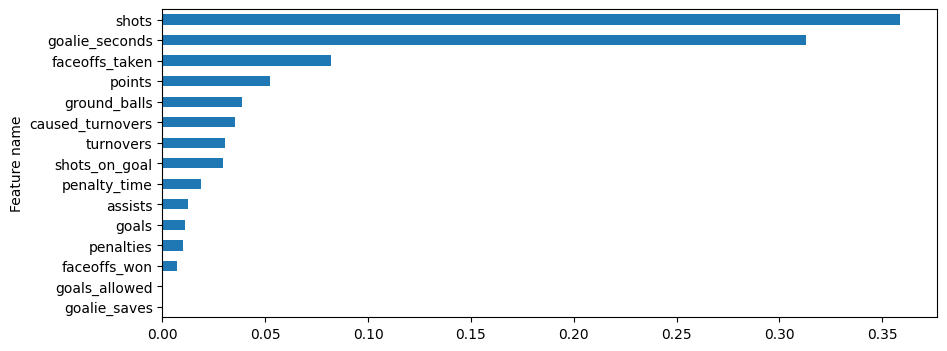

In [15]:
feats = df_noblanks.drop('position', axis=1)

mdi_importances = pd.Series(dectree_clf.feature_importances_, index=feats.columns)

plt.figure(figsize=(10,4))
plt.xlabel("Feature importance value")
plt.ylabel("Feature name")
mdi_importances.sort_values().plot.barh()
#plt.title('Decision Tree Feature Importance')
plt.show()

Interesting. Goalie_seconds and shots are by far important with faceoff_taken and points coming next.

Do some ablation by removing important and unimportant features and see what the scores come out to be

In [53]:
#remove goalie saves, goals allowed, penalties, faceoffs won
X2 = df_noblanks.drop(['position','goalie_saves','goals_allowed','penalties','faceoffs_won'], axis=1).values
y2 = df_noblanks['position'].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42)
dectree_clf2 = DecisionTreeClassifier().fit(X_train2, y_train2)
print('dec tree 2 training accuracy: {:.4f}'.format(dectree_clf2.score(X_train2,y_train2)))
print('dec tree 2 test accuracy: {:.4f}'.format(dectree_clf2.score(X_test2, y_test2)))

dec tree 2 training accuracy: 0.8154
dec tree 2 test accuracy: 0.7111


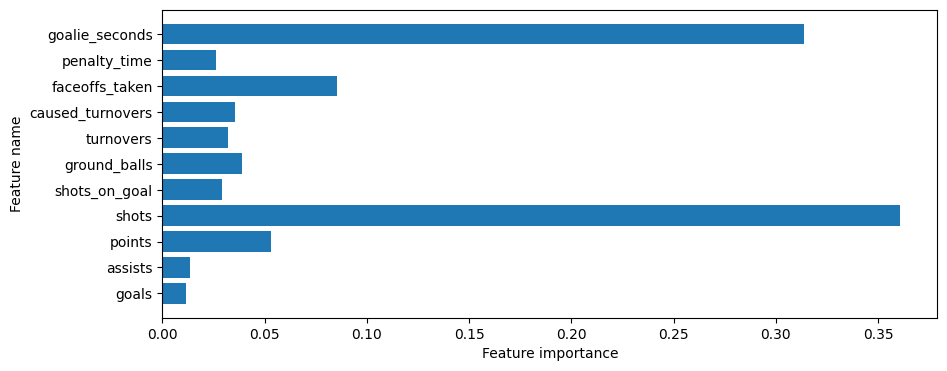

In [54]:
ablation1 = df_noblanks.drop(['position','goalie_saves','goals_allowed','penalties','faceoffs_won'], axis=1)
plt.figure(figsize=(10,4))
plot_feature_importances(dectree_clf2, ablation1.columns)
plt.show()

As expected. Removing features that have little or no importance didn't change the accuracy.

In [23]:
#remove goals, assists, penalty time, shots on goal
X3 = ablation1.drop(['goals','assists','penalty_time','shots_on_goal'], axis=1).values
y3 = df_noblanks['position'].values
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, random_state=42)
dectree_clf3 = DecisionTreeClassifier().fit(X_train3, y_train3)
print('dec tree 3 training accuracy: {:.4f}'.format(dectree_clf3.score(X_train3,y_train3)))
print('dec tree 3 test accuracy: {:.4f}'.format(dectree_clf3.score(X_test3, y_test3)))

dec tree 3 training accuracy: 0.7651
dec tree 3 test accuracy: 0.7245


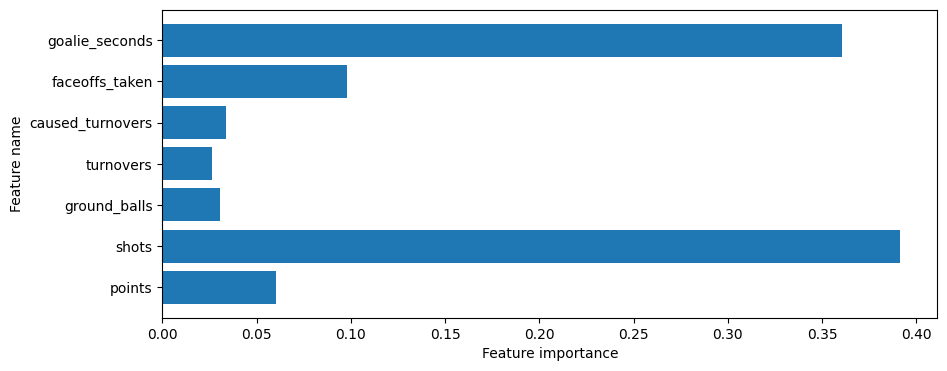

In [24]:
ablation2 = ablation1.drop(['goals','assists','penalty_time','shots_on_goal'], axis=1)
plt.figure(figsize=(10,4))
plot_feature_importances(dectree_clf3, ablation2.columns)
plt.show()

Interesting. Accuracy on the training set got lower, but the test set increase by ~1.3%.

One more round of removing unimportant features.

In [25]:
#remove turnovers, caused turnovers, ground balls
X4 = ablation2.drop(['turnovers','caused_turnovers','ground_balls'], axis=1).values
y4 = df_noblanks['position'].values
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, random_state=42)
dectree_clf4 = DecisionTreeClassifier().fit(X_train4, y_train4)
print('dec tree 4 training accuracy: {:.4f}'.format(dectree_clf4.score(X_train4,y_train4)))
print('dec tree 4 test accuracy: {:.4f}'.format(dectree_clf4.score(X_test4, y_test4)))

dec tree 4 training accuracy: 0.7250
dec tree 4 test accuracy: 0.7204


Training accuracy got much worse and test accuracy went down slightly. 

What happens when one of the top 2 features is removed?

In [28]:
#remove shots
X5 = df_noblanks.drop(['position','shots'], axis=1).values
y5 = df_noblanks['position'].values
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, random_state=42)
dectree_clf5 = DecisionTreeClassifier().fit(X_train5, y_train5)
print('dec tree 5 training accuracy: {:.4f}'.format(dectree_clf5.score(X_train5,y_train5)))
print('dec tree 5 test accuracy: {:.4f}'.format(dectree_clf5.score(X_test5, y_test5)))

dec tree 5 training accuracy: 0.7757
dec tree 5 test accuracy: 0.7098


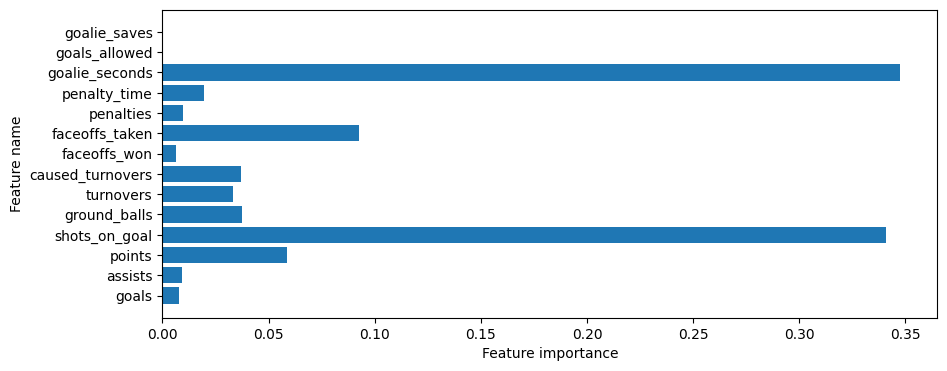

In [30]:
ablation5 = df_noblanks.drop(['position','shots'], axis=1)
plt.figure(figsize=(10,4))
plot_feature_importances(dectree_clf5, ablation5.columns)
plt.show()

Test accuracy remains the same. Instead of shots being important, shots on goal moved up. I'm going to take that out too.

In [31]:
#remove shots on goal
X6 = ablation5.drop('shots_on_goal', axis=1).values
y6 = df_noblanks['position'].values
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, random_state=42)
dectree_clf6 = DecisionTreeClassifier().fit(X_train6, y_train6)
print('dec tree 6 training accuracy: {:.4f}'.format(dectree_clf6.score(X_train6,y_train6)))
print('dec tree 6 test accuracy: {:.4f}'.format(dectree_clf6.score(X_test6, y_test6)))

dec tree 6 training accuracy: 0.7383
dec tree 6 test accuracy: 0.6991


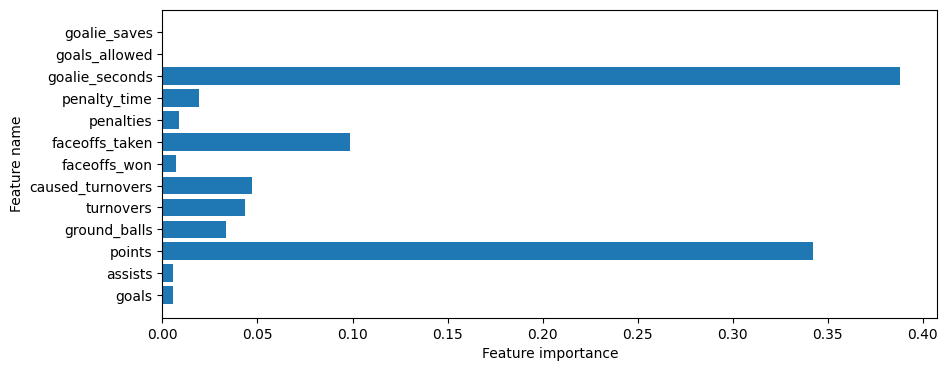

In [33]:
ablation6 = ablation5.drop('shots_on_goal', axis=1)
plt.figure(figsize=(10,4))
plot_feature_importances(dectree_clf6, ablation6.columns)
plt.show()

Lost ~1% of accuracy by removing both shots and shots on goal. With both of those gone, points becomes an important feature.

Next, I'm going back to the original df and removing goalie_seconds. Let's see what happens to goals allowed and goalie saves.

In [34]:
#remove goalie seconds
X7 = df_noblanks.drop(['position','goalie_seconds'], axis=1).values
y7 = df_noblanks['position'].values
X_train7, X_test7, y_train7, y_test7 = train_test_split(X7, y7, random_state=42)
dectree_clf7 = DecisionTreeClassifier().fit(X_train7, y_train7)
print('dec tree 7 training accuracy: {:.4f}'.format(dectree_clf7.score(X_train7,y_train7)))
print('dec tree 7 test accuracy: {:.4f}'.format(dectree_clf7.score(X_test7, y_test7)))

dec tree 7 training accuracy: 0.8171
dec tree 7 test accuracy: 0.7092


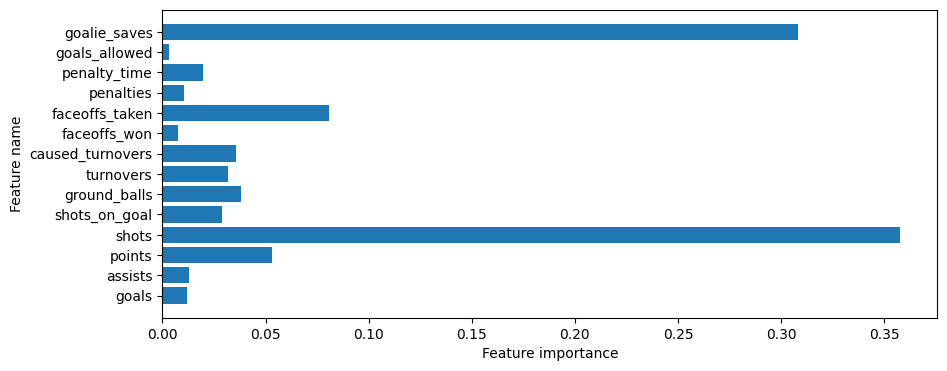

In [35]:
ablation7 = df_noblanks.drop(['position','goalie_seconds'], axis=1)
plt.figure(figsize=(10,4))
plot_feature_importances(dectree_clf7, ablation7.columns)
plt.show()

That's a surprise! Both training and test accuracy are about as good as the original classifier. Goalie saves is now the important factor. You know what's next...remove goalie saves.

In [37]:
#remove goalie saves
X8 = ablation7.drop('goalie_saves', axis=1).values
y8 = df_noblanks['position'].values
X_train8, X_test8, y_train8, y_test8 = train_test_split(X8, y8, random_state=42)
dectree_clf8 = DecisionTreeClassifier().fit(X_train8, y_train8)
print('dec tree 8 training accuracy: {:.4f}'.format(dectree_clf8.score(X_train8,y_train8)))
print('dec tree 8 test accuracy: {:.4f}'.format(dectree_clf8.score(X_test8, y_test8)))

dec tree 8 training accuracy: 0.8151
dec tree 8 test accuracy: 0.7071


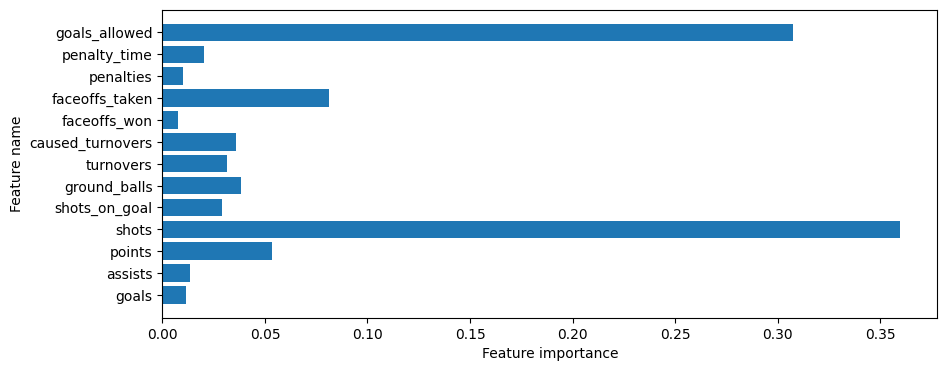

In [38]:
ablation8 = ablation7.drop('goalie_saves', axis=1)
plt.figure(figsize=(10,4))
plot_feature_importances(dectree_clf8, ablation8.columns)
plt.show()

Hmm...I expected the importance to shift to the last remaining goalie category. Both training and test accuracy are still good. Both are a little lower than the original, but close enough.

Ultimately, goalie seconds is still more important than goalie saves and goals allowed

In [59]:
#remove goals, assists, penalty time, shots on goal, goalie saves, goals allowed, faceoffs won
X9 = df_noblanks.drop(['position','goals','assists','faceoffs_won','penalty_time','shots_on_goal','goalie_saves','goals_allowed'], axis=1).values
y9 = df_noblanks['position'].values
X_train9, X_test9, y_train9, y_test9 = train_test_split(X9, y9, random_state=42)
dectree_clf9 = DecisionTreeClassifier().fit(X_train9, y_train9)
print('dec tree 9 training accuracy: {:.4f}'.format(dectree_clf9.score(X_train9,y_train9)))
print('dec tree 9 test accuracy: {:.4f}'.format(dectree_clf9.score(X_test9, y_test9)))

dec tree 9 training accuracy: 0.7759
dec tree 9 test accuracy: 0.7221


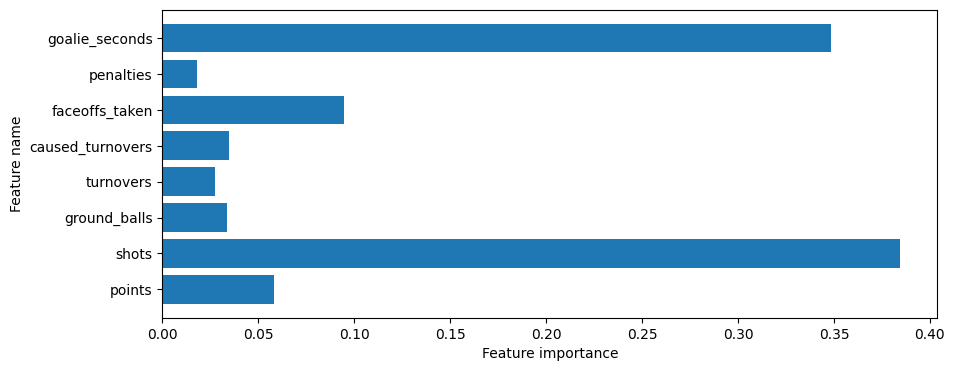

In [60]:
ablation9 = df_noblanks.drop(['position','goals','assists','faceoffs_won', 'penalty_time','shots_on_goal','goalie_saves','goals_allowed'], axis=1)
plt.figure(figsize=(10,4))
plot_feature_importances(dectree_clf9, ablation9.columns)
plt.show()

72.2% test accuracy with 8 of the original 15 features

Trying a decision tree with max depth = 3

In [19]:
#dectree_clf2 = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
#print('training accuracy: {:.2f}'.format(dectree_clf2.score(X_train,y_train)))
#print('test accuracy: {:.2f}'.format(dectree_clf2.score(X_test, y_test)))

training accuracy: 0.71
test accuracy: 0.71
